
# Problem 1 -> 

## Predicting the patient's eligibility to a given target drug in next 30 days.

Data Description - The data folder contains following files

1) Train.parquet - Dataset to be used for training
2) Test.parquet - Dataset to be used for testing
3) Sample_submission.csv - a sample csv file showing how the output should be
4) Final_submission.csv - csv file to be submitted finally after generating the output

## Brief Description of the Dataset -


The dataset in question contains a comprehensive collection of electronic health records belonging to patients who have been diagnosed with a specific disease. These health records comprise a detailed log of every aspect of the patients' medical history, including all diagnoses, symptoms, prescribed drug treatments, and medical tests that they have undergone. Each row represents a healthcare record/medical event for a patient and it includes a timestamp for each entry/event, thereby allowing for a chronological view of the patient's medical history.

The Data has mainly three columns

1) Patient-Uid - Unique Alphanumeric Identifier for a patient
2) Date - Date when patient encountered the event.
3) Incident - This columns describes which event occurred on the day.

### Install Required Packages 

In [1]:
!pip install fastparquet
!pip install tensorflow
!pip install scikit-learn
!pip install xgboost
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_auc_score as ras, roc_curve, auc, accuracy_score




In [3]:
#To ignore warnings
import warnings
warnings.filterwarnings("ignore")

### **Loading Dataset - Train**

In [4]:
train_df=pd.read_parquet("train.parquet")

### **Analysis of Data**

In [5]:
# Checking size of dataset
print("Train data set size : ", train_df.shape)

Train data set size :  (3220868, 3)


In [6]:
train_df.head()

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1


- Above Table represents a patient journey for patient "a0db1e73-1c7c-11ec-ae39-16262ee38c7f" The patient had a symptom of type 0 on 2018-01-30 and then This patient took drug of type 0 on 2015-04-2022, then again the patient took drug of type 1 on 2016-06-18 and so on

In [7]:
train_df.columns

Index(['Patient-Uid', 'Date', 'Incident'], dtype='object')

In [8]:
train_df.describe()

,Date
count,3220868
mean,2018-02-24 18:27:44.495410944
min,2015-04-07 00:00:00
25%,2016-11-30 00:00:00
50%,2018-04-11 00:00:00
75%,2019-05-30 00:00:00
max,2020-09-03 00:00:00


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3220868 entries, 0 to 29080911
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Patient-Uid  object        
 1   Date         datetime64[ns]
 2   Incident     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 98.3+ MB


In [10]:
counts = train_df['Patient-Uid'].value_counts()
counts.shape

(27033,)

In [11]:
counts = train_df['Incident'].value_counts()['TARGET DRUG']
counts

67218

- There are total 27,033 unique patients present in train.
There is also drug called ‘Target Drug”, this drug is of interest for the assignment, there are total 9K patients in train.parquet who have taken “Target Drug” atleast once.

In [12]:
counts = train_df['Incident'].value_counts()
counts.shape

(57,)

# Data Preprocessing

## Data Cleaning

- Data cleaning is the process of identifying and correcting or removing errors, inconsistencies, and inaccuracies in a dataset to improve its quality and ensure that it is ready for analysis. It involves tasks such as handling missing or duplicate data, correcting data types, and removing outliers or irrelevant information.

### Missing Values

In [13]:
#checking for null values
train_df.isnull().sum()

Patient-Uid    0
Date           0
Incident       0
dtype: int64

### Finding Duplicate Values

In [14]:
#checking for no of duplicate values
train_df.duplicated().sum()

35571

- We can clearly understand 35571 values are duplicate. There is no use of duplicate values so we will delete all duplicate values.

In [15]:
#droping duplicates
train_df = train_df.drop_duplicates()

In [16]:
#after droping again check for no of duplicates
train_df.duplicated().sum()

0

## Checking Data Type

In [17]:
train_df.dtypes

Patient-Uid            object
Date           datetime64[ns]
Incident               object
dtype: object

## Unique Values of Incident Column

In [18]:
print("Unique values of Incident \n")
print(train_df['Incident'].unique())

Unique values of Incident 

['PRIMARY_DIAGNOSIS' 'SYMPTOM_TYPE_0' 'DRUG_TYPE_0' 'DRUG_TYPE_1'
 'DRUG_TYPE_2' 'TEST_TYPE_0' 'DRUG_TYPE_3' 'DRUG_TYPE_4' 'DRUG_TYPE_5'
 'DRUG_TYPE_6' 'DRUG_TYPE_8' 'DRUG_TYPE_7' 'SYMPTOM_TYPE_1' 'DRUG_TYPE_10'
 'SYMPTOM_TYPE_29' 'SYMPTOM_TYPE_2' 'DRUG_TYPE_11' 'DRUG_TYPE_9'
 'DRUG_TYPE_13' 'SYMPTOM_TYPE_5' 'TEST_TYPE_1' 'SYMPTOM_TYPE_6'
 'TEST_TYPE_2' 'SYMPTOM_TYPE_3' 'SYMPTOM_TYPE_8' 'DRUG_TYPE_14'
 'DRUG_TYPE_12' 'SYMPTOM_TYPE_9' 'SYMPTOM_TYPE_10' 'SYMPTOM_TYPE_7'
 'SYMPTOM_TYPE_11' 'TEST_TYPE_3' 'DRUG_TYPE_15' 'SYMPTOM_TYPE_4'
 'SYMPTOM_TYPE_14' 'SYMPTOM_TYPE_13' 'SYMPTOM_TYPE_16' 'SYMPTOM_TYPE_17'
 'SYMPTOM_TYPE_15' 'SYMPTOM_TYPE_18' 'SYMPTOM_TYPE_12' 'SYMPTOM_TYPE_20'
 'SYMPTOM_TYPE_21' 'DRUG_TYPE_17' 'SYMPTOM_TYPE_22' 'TEST_TYPE_4'
 'SYMPTOM_TYPE_23' 'DRUG_TYPE_16' 'TEST_TYPE_5' 'SYMPTOM_TYPE_19'
 'SYMPTOM_TYPE_24' 'SYMPTOM_TYPE_25' 'SYMPTOM_TYPE_26' 'SYMPTOM_TYPE_27'
 'DRUG_TYPE_18' 'SYMPTOM_TYPE_28' 'TARGET DRUG']


In [19]:
train_indexes= counts.index
print(train_indexes)

Index(['DRUG_TYPE_6', 'DRUG_TYPE_1', 'PRIMARY_DIAGNOSIS', 'DRUG_TYPE_0',
       'DRUG_TYPE_7', 'DRUG_TYPE_2', 'DRUG_TYPE_8', 'DRUG_TYPE_3',
       'TEST_TYPE_1', 'TARGET DRUG', 'DRUG_TYPE_9', 'DRUG_TYPE_5',
       'DRUG_TYPE_11', 'SYMPTOM_TYPE_0', 'SYMPTOM_TYPE_6', 'TEST_TYPE_0',
       'SYMPTOM_TYPE_7', 'DRUG_TYPE_10', 'DRUG_TYPE_14', 'DRUG_TYPE_13',
       'DRUG_TYPE_12', 'SYMPTOM_TYPE_14', 'SYMPTOM_TYPE_1', 'SYMPTOM_TYPE_2',
       'TEST_TYPE_3', 'SYMPTOM_TYPE_5', 'SYMPTOM_TYPE_8', 'TEST_TYPE_2',
       'SYMPTOM_TYPE_15', 'SYMPTOM_TYPE_10', 'SYMPTOM_TYPE_29',
       'SYMPTOM_TYPE_16', 'DRUG_TYPE_15', 'SYMPTOM_TYPE_9', 'DRUG_TYPE_4',
       'SYMPTOM_TYPE_4', 'SYMPTOM_TYPE_3', 'SYMPTOM_TYPE_12',
       'SYMPTOM_TYPE_11', 'SYMPTOM_TYPE_17', 'SYMPTOM_TYPE_13', 'DRUG_TYPE_16',
       'TEST_TYPE_4', 'SYMPTOM_TYPE_18', 'SYMPTOM_TYPE_21', 'SYMPTOM_TYPE_22',
       'SYMPTOM_TYPE_19', 'DRUG_TYPE_17', 'TEST_TYPE_5', 'SYMPTOM_TYPE_24',
       'SYMPTOM_TYPE_26', 'SYMPTOM_TYPE_23', 'SYMPTOM_TYPE_

### **Exploring the Dataset**

In [20]:
#no of counts for particular Incident
train_df.Incident.value_counts()

Incident
DRUG_TYPE_6          549616
DRUG_TYPE_1          484565
PRIMARY_DIAGNOSIS    424879
DRUG_TYPE_0          298881
DRUG_TYPE_2          256203
DRUG_TYPE_7          251239
DRUG_TYPE_8          158706
DRUG_TYPE_3          126615
TEST_TYPE_1           96810
TARGET DRUG           67218
DRUG_TYPE_9           66894
DRUG_TYPE_5           55940
SYMPTOM_TYPE_0        46078
DRUG_TYPE_11          45419
SYMPTOM_TYPE_6        32066
TEST_TYPE_0           27570
SYMPTOM_TYPE_7        22019
DRUG_TYPE_10          20911
DRUG_TYPE_14          17306
DRUG_TYPE_13          12321
DRUG_TYPE_12           9540
SYMPTOM_TYPE_14        8927
SYMPTOM_TYPE_1         8608
SYMPTOM_TYPE_2         8168
TEST_TYPE_3            8115
SYMPTOM_TYPE_5         7583
SYMPTOM_TYPE_8         7430
TEST_TYPE_2            7021
SYMPTOM_TYPE_15        6295
SYMPTOM_TYPE_10        6005
SYMPTOM_TYPE_29        5910
SYMPTOM_TYPE_16        4940
DRUG_TYPE_15           4906
SYMPTOM_TYPE_9         4885
DRUG_TYPE_4            4566
SYMPTOM_TYP

In [21]:
#no of counts for particular Date
train_df.Date.value_counts()

Date
2019-05-21    3645
2019-05-22    3330
2019-03-05    3156
2019-05-14    3134
2019-03-12    2986
              ... 
2017-01-27     308
2017-02-28     285
2020-02-29     282
2016-01-29     271
2016-02-29     255
Name: count, Length: 1977, dtype: int64

In [22]:
# generating positive set
positive_df = train_df[train_df['Incident']=='TARGET DRUG']
positive_df.head()

,Patient-Uid,Date,Incident
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG


In [23]:
# shape of positive set
positive_df.shape

(67218, 3)

In [24]:
negative =  train_df[~train_df['Patient-Uid'].isin(positive_df['Patient-Uid'])]
negative_df = negative.groupby('Patient-Uid').tail(1)
negative_df

,Patient-Uid,Date,Incident
1560892,a0e3a8c0-1c7c-11ec-98c2-16262ee38c7f,2018-05-06,PRIMARY_DIAGNOSIS
1620903,a0dd6a3f-1c7c-11ec-9b86-16262ee38c7f,2015-04-07,SYMPTOM_TYPE_0
1629044,a0e48a75-1c7c-11ec-8c5f-16262ee38c7f,2018-08-22,DRUG_TYPE_6
1942882,a0e3cf61-1c7c-11ec-8098-16262ee38c7f,2018-08-21,DRUG_TYPE_2
1975541,a0e91a8c-1c7c-11ec-acc2-16262ee38c7f,2020-04-15,PRIMARY_DIAGNOSIS
...,...,...,...
3256795,a0e045a1-1c7c-11ec-8014-16262ee38c7f,2020-07-10,PRIMARY_DIAGNOSIS
3256799,a0e67e2a-1c7c-11ec-b805-16262ee38c7f,2015-12-16,PRIMARY_DIAGNOSIS
3256800,a0dec400-1c7c-11ec-80df-16262ee38c7f,2019-08-06,PRIMARY_DIAGNOSIS
3256804,a0e09919-1c7c-11ec-9e7d-16262ee38c7f,2017-02-19,DRUG_TYPE_6


In [25]:
# shape of negative set
negative_df.shape

(17659, 3)

In [26]:
# to get the count of previous prescriptions within specific time intervals
positive_df['Prescription_Count'] = positive_df.groupby('Patient-Uid')['Date'].cumcount()
negative_df['Prescription_Count'] = negative_df.groupby('Patient-Uid')['Date'].cumcount()
positive_df.tail(5)

,Patient-Uid,Date,Incident,Prescription_Count
29074998,a0ef2b6d-1c7c-11ec-9172-16262ee38c7f,2018-10-12,TARGET DRUG,4
29075105,a0ebe423-1c7c-11ec-a5e0-16262ee38c7f,2019-07-02,TARGET DRUG,9
29075494,a0ebc713-1c7c-11ec-bd53-16262ee38c7f,2019-05-21,TARGET DRUG,10
29080031,a0ee1bdb-1c7c-11ec-90ba-16262ee38c7f,2018-06-07,TARGET DRUG,14
29080178,a0eef180-1c7c-11ec-8de8-16262ee38c7f,2018-07-17,TARGET DRUG,13


In [27]:
negative_df.tail(5)

,Patient-Uid,Date,Incident,Prescription_Count
3256795,a0e045a1-1c7c-11ec-8014-16262ee38c7f,2020-07-10,PRIMARY_DIAGNOSIS,0
3256799,a0e67e2a-1c7c-11ec-b805-16262ee38c7f,2015-12-16,PRIMARY_DIAGNOSIS,0
3256800,a0dec400-1c7c-11ec-80df-16262ee38c7f,2019-08-06,PRIMARY_DIAGNOSIS,0
3256804,a0e09919-1c7c-11ec-9e7d-16262ee38c7f,2017-02-19,DRUG_TYPE_6,0
3256805,a0e69331-1c7c-11ec-a98d-16262ee38c7f,2015-10-03,DRUG_TYPE_6,0


In [28]:
# to get the difference between the most recent prescription and the prediction date.
prediction_date = pd.to_datetime('today') + pd.DateOffset(days=30)
positive_df['Time_diff'] = (prediction_date - positive_df.groupby('Patient-Uid')['Date'].transform('max')).dt.days
negative_df['Time_diff'] = (prediction_date - negative_df.groupby('Patient-Uid')['Date'].transform('max')).dt.days

In [29]:
positive_df.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_diff
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG,0,1197
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG,0,1451
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG,0,1476
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG,0,1181
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG,0,1197


In [30]:
negative_df.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_diff
1560892,a0e3a8c0-1c7c-11ec-98c2-16262ee38c7f,2018-05-06,PRIMARY_DIAGNOSIS,0,2027
1620903,a0dd6a3f-1c7c-11ec-9b86-16262ee38c7f,2015-04-07,SYMPTOM_TYPE_0,0,3152
1629044,a0e48a75-1c7c-11ec-8c5f-16262ee38c7f,2018-08-22,DRUG_TYPE_6,0,1919
1942882,a0e3cf61-1c7c-11ec-8098-16262ee38c7f,2018-08-21,DRUG_TYPE_2,0,1920
1975541,a0e91a8c-1c7c-11ec-acc2-16262ee38c7f,2020-04-15,PRIMARY_DIAGNOSIS,0,1317


In [31]:
# creating new dataset by concating positive and negative sets
new_df = pd.concat([positive_df, negative_df])
new_df.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_diff
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG,0,1197
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG,0,1451
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG,0,1476
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG,0,1181
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG,0,1197


In [32]:
new_df.shape

(84877, 5)

In [33]:
# splitting dataset into train & test sets
X_train,X_test,Y_train,Y_test = X_train, X_test, Y_train, Y_test = train_test_split(new_df[['Prescription_Count', 'Time_diff']], new_df['Incident'] == 'TARGET DRUG', test_size = 0.25, random_state=42)


In [34]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((63657, 2), (21220, 2), (63657,), (21220,))

In [35]:

# building model to train the data
xgb_classifier =  XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [36]:
#predicting test data
y_pred = xgb_classifier.predict(X_test)

In [37]:
# to evaluate the model - confusion_matrix
conf_matrix_report = confusion_matrix(Y_test, y_pred)
conf_matrix_report

array([[ 4015,   377],
       [  895, 15933]])

In [38]:
# evaluating the model - classification report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.91      0.86      4392
        True       0.98      0.95      0.96     16828

    accuracy                           0.94     21220
   macro avg       0.90      0.93      0.91     21220
weighted avg       0.94      0.94      0.94     21220



In [39]:
# calculating F1 score
F1_score = f1_score(Y_test, y_pred)
F1_score


0.9616150642766613

In [40]:
# model accuracy
accuracy_score(Y_test, y_pred)

0.9400565504241282

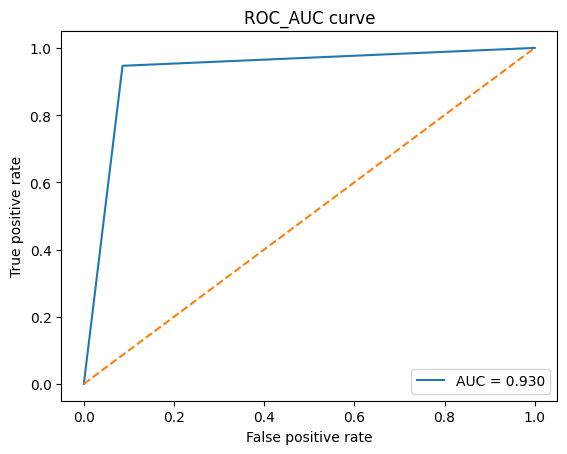

In [41]:
# evaluating model by roc_auc curve
fpr,tpr, thresold = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr, label = 'AUC = %0.3f' % roc_auc)
plt.plot([0,1],[0,1],'--')
plt.title('ROC_AUC curve')
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### **Loading Dataset - Test Data**

In [42]:
test_df = pd.read_parquet("test.parquet")

### **Analysis of Data**

In [43]:
# Checking size of dataset
print("Data set size : ", test_df.shape)

Data set size :  (1065524, 3)


- From the above result no of rows are 1065524 and no of columns are 3

In [44]:
#Fetching top 5 row in dataset
test_df.head()

,Patient-Uid,Date,Incident
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2016-12-08,SYMPTOM_TYPE_0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-10-17,DRUG_TYPE_0
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,DRUG_TYPE_2
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-12-05,DRUG_TYPE_1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-11-04,SYMPTOM_TYPE_0


In [45]:
#Fetching Bottom 5 rows
test_df.tail()

,Patient-Uid,Date,Incident
1372854,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-05-11,DRUG_TYPE_13
1372856,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2018-08-22,DRUG_TYPE_2
1372857,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-02-04,DRUG_TYPE_2
1372858,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-09-25,DRUG_TYPE_8
1372859,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-05-19,DRUG_TYPE_7


In [46]:
#finding the column names
test_df.columns

Index(['Patient-Uid', 'Date', 'Incident'], dtype='object')

In [47]:
#Basic statistical analysis of dataset
test_df.describe()

,Date
count,1065524
mean,2017-09-01 15:54:13.488799488
min,2015-04-07 00:00:00
25%,2016-07-26 00:00:00
50%,2017-09-11 00:00:00
75%,2018-09-26 00:00:00
max,2020-08-04 00:00:00


### **Data Preprocessing**
### **Data Cleaning - Missing Values**

In [48]:
#checking for null values
test_df.isnull().sum()

Patient-Uid    0
Date           0
Incident       0
dtype: int64

### **Finding Duplicate Values**

In [49]:
#checking for no of duplicate values
test_df.duplicated().sum()

12100

- From the above result we can find 12100 duplicate datas. So will drop the duplicates.

In [50]:
#droping duplicates
test_df = test_df.drop_duplicates()

In [51]:
#after droping agin check for no of duplicates
test_df.duplicated().sum()

0

- Duplicates are removed from dataset.

### **Checking Data Type**

In [52]:
test_df.dtypes

Patient-Uid            object
Date           datetime64[ns]
Incident               object
dtype: object

### **Unique Values of Incident**

In [53]:
print("Unique values of Incident \n")
print(test_df['Incident'].unique())

Unique values of Incident 

['SYMPTOM_TYPE_0' 'DRUG_TYPE_0' 'DRUG_TYPE_2' 'DRUG_TYPE_1'
 'PRIMARY_DIAGNOSIS' 'DRUG_TYPE_8' 'TEST_TYPE_0' 'DRUG_TYPE_7'
 'DRUG_TYPE_11' 'SYMPTOM_TYPE_6' 'DRUG_TYPE_5' 'DRUG_TYPE_6' 'DRUG_TYPE_9'
 'DRUG_TYPE_15' 'TEST_TYPE_3' 'SYMPTOM_TYPE_3' 'TEST_TYPE_1' 'DRUG_TYPE_3'
 'TEST_TYPE_2' 'SYMPTOM_TYPE_7' 'DRUG_TYPE_12' 'SYMPTOM_TYPE_2'
 'SYMPTOM_TYPE_10' 'SYMPTOM_TYPE_1' 'SYMPTOM_TYPE_17' 'SYMPTOM_TYPE_18'
 'SYMPTOM_TYPE_5' 'SYMPTOM_TYPE_15' 'SYMPTOM_TYPE_9' 'SYMPTOM_TYPE_4'
 'SYMPTOM_TYPE_8' 'SYMPTOM_TYPE_29' 'DRUG_TYPE_13' 'SYMPTOM_TYPE_21'
 'DRUG_TYPE_4' 'SYMPTOM_TYPE_12' 'SYMPTOM_TYPE_11' 'SYMPTOM_TYPE_19'
 'DRUG_TYPE_14' 'SYMPTOM_TYPE_16' 'TEST_TYPE_4' 'DRUG_TYPE_10'
 'SYMPTOM_TYPE_26' 'SYMPTOM_TYPE_14' 'SYMPTOM_TYPE_24' 'DRUG_TYPE_16'
 'SYMPTOM_TYPE_13' 'TEST_TYPE_5' 'SYMPTOM_TYPE_20' 'SYMPTOM_TYPE_25'
 'SYMPTOM_TYPE_22' 'DRUG_TYPE_17' 'SYMPTOM_TYPE_27' 'SYMPTOM_TYPE_23'
 'SYMPTOM_TYPE_28']


### **Exploring the Dataset**

In [54]:
#no of counts for particular Incident
test_df.Incident.value_counts()

Incident
DRUG_TYPE_6          188401
DRUG_TYPE_1          169089
PRIMARY_DIAGNOSIS    127996
DRUG_TYPE_0           90711
DRUG_TYPE_2           90465
DRUG_TYPE_7           90423
DRUG_TYPE_8           55696
DRUG_TYPE_3           40679
TEST_TYPE_1           34274
DRUG_TYPE_9           25294
DRUG_TYPE_5           20045
SYMPTOM_TYPE_0        17292
DRUG_TYPE_11          16587
SYMPTOM_TYPE_6        11536
TEST_TYPE_0           10921
SYMPTOM_TYPE_7         7943
SYMPTOM_TYPE_5         5403
DRUG_TYPE_14           4963
DRUG_TYPE_10           4242
DRUG_TYPE_13           4059
SYMPTOM_TYPE_1         2955
DRUG_TYPE_12           2823
SYMPTOM_TYPE_2         2772
TEST_TYPE_3            2709
SYMPTOM_TYPE_8         2683
TEST_TYPE_2            2524
SYMPTOM_TYPE_14        2482
DRUG_TYPE_4            1840
SYMPTOM_TYPE_15        1818
SYMPTOM_TYPE_10        1783
SYMPTOM_TYPE_29        1697
SYMPTOM_TYPE_9         1689
SYMPTOM_TYPE_16        1576
DRUG_TYPE_15           1373
SYMPTOM_TYPE_4         1315
SYMPTOM_TYP

In [55]:
# generating positive set
positive_df = test_df[test_df['Incident']=='TARGET DRUG']
positive_df.head()


,Patient-Uid,Date,Incident


In [56]:
# shape of positive set
positive_df.shape

(0, 3)

In [57]:
negative =  test_df[~test_df['Patient-Uid'].isin(positive_df['Patient-Uid'])]
negative_df = negative.groupby('Patient-Uid').tail(1)
negative_df

,Patient-Uid,Date,Incident
57,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,TEST_TYPE_0
208,a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,2016-06-22,DRUG_TYPE_9
305,a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,2019-07-21,DRUG_TYPE_6
420,a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,2016-06-15,DRUG_TYPE_6
497,a0f9eab1-1c7c-11ec-a732-16262ee38c7f,2018-11-22,DRUG_TYPE_6
...,...,...,...
1372381,a102720c-1c7c-11ec-bd9a-16262ee38c7f,2020-01-07,DRUG_TYPE_6
1372432,a102723c-1c7c-11ec-9f80-16262ee38c7f,2019-07-06,DRUG_TYPE_3
1372543,a102726b-1c7c-11ec-bfbf-16262ee38c7f,2018-12-31,DRUG_TYPE_0
1372607,a102729b-1c7c-11ec-86ba-16262ee38c7f,2019-04-02,DRUG_TYPE_3


In [58]:
# shape of negative set
negative_df.shape

(11482, 3)

In [59]:
# to get the count of previous prescriptions within specific time intervals
positive_df['Prescription_Count'] = positive_df.groupby('Patient-Uid')['Date'].cumcount()
negative_df['Prescription_Count'] = negative_df.groupby('Patient-Uid')['Date'].cumcount()
positive_df.tail(5)

,Patient-Uid,Date,Incident,Prescription_Count


In [60]:
negative_df.tail()

,Patient-Uid,Date,Incident,Prescription_Count
1372381,a102720c-1c7c-11ec-bd9a-16262ee38c7f,2020-01-07,DRUG_TYPE_6,0
1372432,a102723c-1c7c-11ec-9f80-16262ee38c7f,2019-07-06,DRUG_TYPE_3,0
1372543,a102726b-1c7c-11ec-bfbf-16262ee38c7f,2018-12-31,DRUG_TYPE_0,0
1372607,a102729b-1c7c-11ec-86ba-16262ee38c7f,2019-04-02,DRUG_TYPE_3,0
1372859,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-05-19,DRUG_TYPE_7,0


In [61]:
# to get the difference between the most recent prescription and the prediction date.
prediction_date = pd.to_datetime('today') + pd.DateOffset(days=30)
positive_df['Time_diff'] = (prediction_date - positive_df.groupby('Patient-Uid')['Date'].transform('max')).dt.days
negative_df['Time_diff'] = (prediction_date - negative_df.groupby('Patient-Uid')['Date'].transform('max')).dt.days

In [62]:
positive_df.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_diff


In [63]:
negative_df.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_diff
57,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,TEST_TYPE_0,0,2183
208,a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,2016-06-22,DRUG_TYPE_9,0,2710
305,a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,2019-07-21,DRUG_TYPE_6,0,1586
420,a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,2016-06-15,DRUG_TYPE_6,0,2717
497,a0f9eab1-1c7c-11ec-a732-16262ee38c7f,2018-11-22,DRUG_TYPE_6,0,1827


In [64]:
# creating new dataset by concating positive and negative sets
new_df = pd.concat([positive_df, negative_df])
new_df.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_diff
57,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,TEST_TYPE_0,0,2183
208,a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,2016-06-22,DRUG_TYPE_9,0,2710
305,a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,2019-07-21,DRUG_TYPE_6,0,1586
420,a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,2016-06-15,DRUG_TYPE_6,0,2717
497,a0f9eab1-1c7c-11ec-a732-16262ee38c7f,2018-11-22,DRUG_TYPE_6,0,1827


In [65]:
new_df.shape

(11482, 5)

In [66]:
train_df.drop_duplicates(inplace = True)

In [67]:
test_df['Prescription_Count'] = test_df.groupby('Patient-Uid')['Date'].cumcount()
test_df['Time_diff'] = (prediction_date - test_df.groupby('Patient-Uid')['Date'].transform(max)).dt.days

In [68]:
test_data_pred = xgb_classifier.predict(test_df[['Prescription_Count', 'Time_diff']])

In [69]:
test_data_pred

array([0, 1, 1, ..., 1, 1, 1])

In [70]:
# to create final submission file
Final_submission = pd.DataFrame({'Patient-Uid': test_df['Patient-Uid'], 'Prediction': test_data_pred})
Final_submission.head()

,Patient-Uid,Prediction
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1


In [72]:
Final_submission.to_csv('Final_submission.csv', index = False)